In [ ]:
# %%

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from transformers.models.llama import LlamaModel
from transformers.models.gpt2 import GPT2Model
from enum import Enum
from types import SimpleNamespace
from typing import Union
from collections import defaultdict

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %%

class DatasetTypes(Enum):
    WIKI = ("wikitext", "wikitext-2-raw-v1")
    INTERNET = ("allenai/c4", "en")
    CODE = "bigcode/starcoderdata"
    ASSISTANT = "HuggingFaceH4/ultrachat_200k"


class ModelTypes(Enum):
    GPT2 = "gpt2"
    LLAMA = "meta-llama/Meta-Llama-3.1-8B"
    GEMMA = "google/gemma-2-9b-it"


def get_dataset(dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI or dataset_type == DatasetTypes.INTERNET:
        return load_dataset(
            dataset_type.value[0], dataset_type.value[1], streaming=True
        )
    return load_dataset(dataset_type.value, streaming=True)


def get_tokenizer_model(model_type: ModelTypes):
    model_name = model_type.value
    return AutoTokenizer.from_pretrained(
        model_name
    ), AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)


def get_model_config(
    model_type: ModelTypes, model: Union[LlamaModel, GPT2Model, PreTrainedModel]
) -> SimpleNamespace:
    if model_type == ModelTypes.LLAMA:
        return SimpleNamespace(
            n_layer=model.config.num_hidden_layers,
            n_head=model.config.num_attention_heads,
        )
    elif model_type == ModelTypes.GPT2:
        return SimpleNamespace(n_layer=model.config.n_layer, n_head=model.config.n_head)
    else:
        raise ValueError("Model type not supported")

In [ ]:
# %%

dataset = get_dataset(DatasetTypes.INTERNET)

In [ ]:
# %%

# Load tokenizer and model
model_type = ModelTypes.GPT2
tokenizer, model = get_tokenizer_model(model_type)
config = get_model_config(model_type, model)
config

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


namespace(n_layer=12, n_head=12)

In [ ]:
# %%

for name, module in model.named_modules():
    print(name)


transformer
transformer.wte
transformer.wpe
transformer.drop
transformer.h
transformer.h.0
transformer.h.0.ln_1
transformer.h.0.attn
transformer.h.0.attn.c_attn
transformer.h.0.attn.c_proj
transformer.h.0.attn.attn_dropout
transformer.h.0.attn.resid_dropout
transformer.h.0.ln_2
transformer.h.0.mlp
transformer.h.0.mlp.c_fc
transformer.h.0.mlp.c_proj
transformer.h.0.mlp.act
transformer.h.0.mlp.dropout
transformer.h.1
transformer.h.1.ln_1
transformer.h.1.attn
transformer.h.1.attn.c_attn
transformer.h.1.attn.c_proj
transformer.h.1.attn.attn_dropout
transformer.h.1.attn.resid_dropout
transformer.h.1.ln_2
transformer.h.1.mlp
transformer.h.1.mlp.c_fc
transformer.h.1.mlp.c_proj
transformer.h.1.mlp.act
transformer.h.1.mlp.dropout
transformer.h.2
transformer.h.2.ln_1
transformer.h.2.attn
transformer.h.2.attn.c_attn
transformer.h.2.attn.c_proj
transformer.h.2.attn.attn_dropout
transformer.h.2.attn.resid_dropout
transformer.h.2.ln_2
transformer.h.2.mlp
transformer.h.2.mlp.c_fc
transformer.h.2.mlp

In [ ]:
# %%

num_of_samples = 150

In [ ]:
# %%

stream = iter(dataset["train"])

In [ ]:
# %%

min_seq_len = 1024
top_ks = [1, 5, 10, 20]
metric_cumsums = [80, 90, 95, 99]
samples_metrics = list()
cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head, min_seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head, min_seq_len)),
    "worst": torch.ones((config.n_layer, config.n_head, min_seq_len)),
}

In [ ]:
# %%

for i in range(num_of_samples):
    input_text = next(stream)["text"]
    inputs = tokenizer(input_text, return_tensors="pt")
    sequence_length = inputs.input_ids.shape[1]

    while sequence_length <= min_seq_len:
        inputs = tokenizer(input_text, return_tensors="pt")
        input_text = next(stream)["text"]
        sequence_length = inputs.input_ids.shape[1]

    # cap length of input to min sequence length tokens
    inputs_sliced = {
        "input_ids": inputs.input_ids[:, :min_seq_len],
        "attention_mask": inputs.attention_mask[:, :min_seq_len],
    }

    sequence_length = inputs_sliced["input_ids"].shape[1]

    metrics = defaultdict(
        lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
    )

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs_sliced)

    attentions = torch.cat(outputs.attentions, dim=0)
    att_wei = attentions[:, :, -1, :]  # get query projection
    att_wei = torch.sort(att_wei, dim=-1, descending=True).values
    cum_prob = att_wei.cumsum(dim=-1)
    cumsum_metrics["avg"] += cum_prob
    cumsum_metrics["best"] = torch.max(cumsum_metrics["best"], cum_prob)
    cumsum_metrics["worst"] = torch.min(cumsum_metrics["worst"], cum_prob)

    # print(f"{cumsum_metrics["avg"][0, 0, :100]}")
    # print(f"{cumsum_metrics["best"][0, 0, :100]}")
    # print(f"{cumsum_metrics["worst"][0, 0, :100]}")

Token indices sequence length is longer than the specified maximum sequence length for this model (2557 > 1024). Running this sequence through the model will result in indexing errors
`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
# %%

cumsum_metrics["avg"] = cumsum_metrics["avg"] / num_of_samples
cumsum_metrics["avg"].shape

torch.Size([12, 12, 1024])

In [ ]:
# %%

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_confidence_heatmaps(avg_cumsum_metrics):
    num_layers, num_heads, seq_length = avg_cumsum_metrics.shape

    # Create a figure with subplots for each layer
    fig, axes = plt.subplots(num_layers, 1, figsize=(15, 5 * num_layers))
    plt.subplots_adjust(top=0.95)
    fig.suptitle(
        "Confidence Probabilities Heatmap for Each Layer and Head", fontsize=16, y=0.98
    )

    for layer in range(num_layers):
        # Get data for the current layer
        layer_data = avg_cumsum_metrics[layer]

        # Create heatmap for the current layer
        sns.heatmap(
            layer_data,
            ax=axes[layer],
            cmap="viridis",
            cbar_kws={"label": "Confidence Probability"},
        )

        axes[layer].set_title(f"Layer {layer+1}")
        axes[layer].set_xlabel("Sequence Position")
        axes[layer].set_ylabel("Head")

    plt.tight_layout()
    plt.show()

In [ ]:
# %%

avg_cumsum_metrics_np = cumsum_metrics["avg"].numpy()
avg_cumsum_metrics_np[0, 0, :]

array([0.09376191, 0.14422609, 0.18220298, ..., 0.9999999 , 1.        ,
       1.        ], dtype=float32)

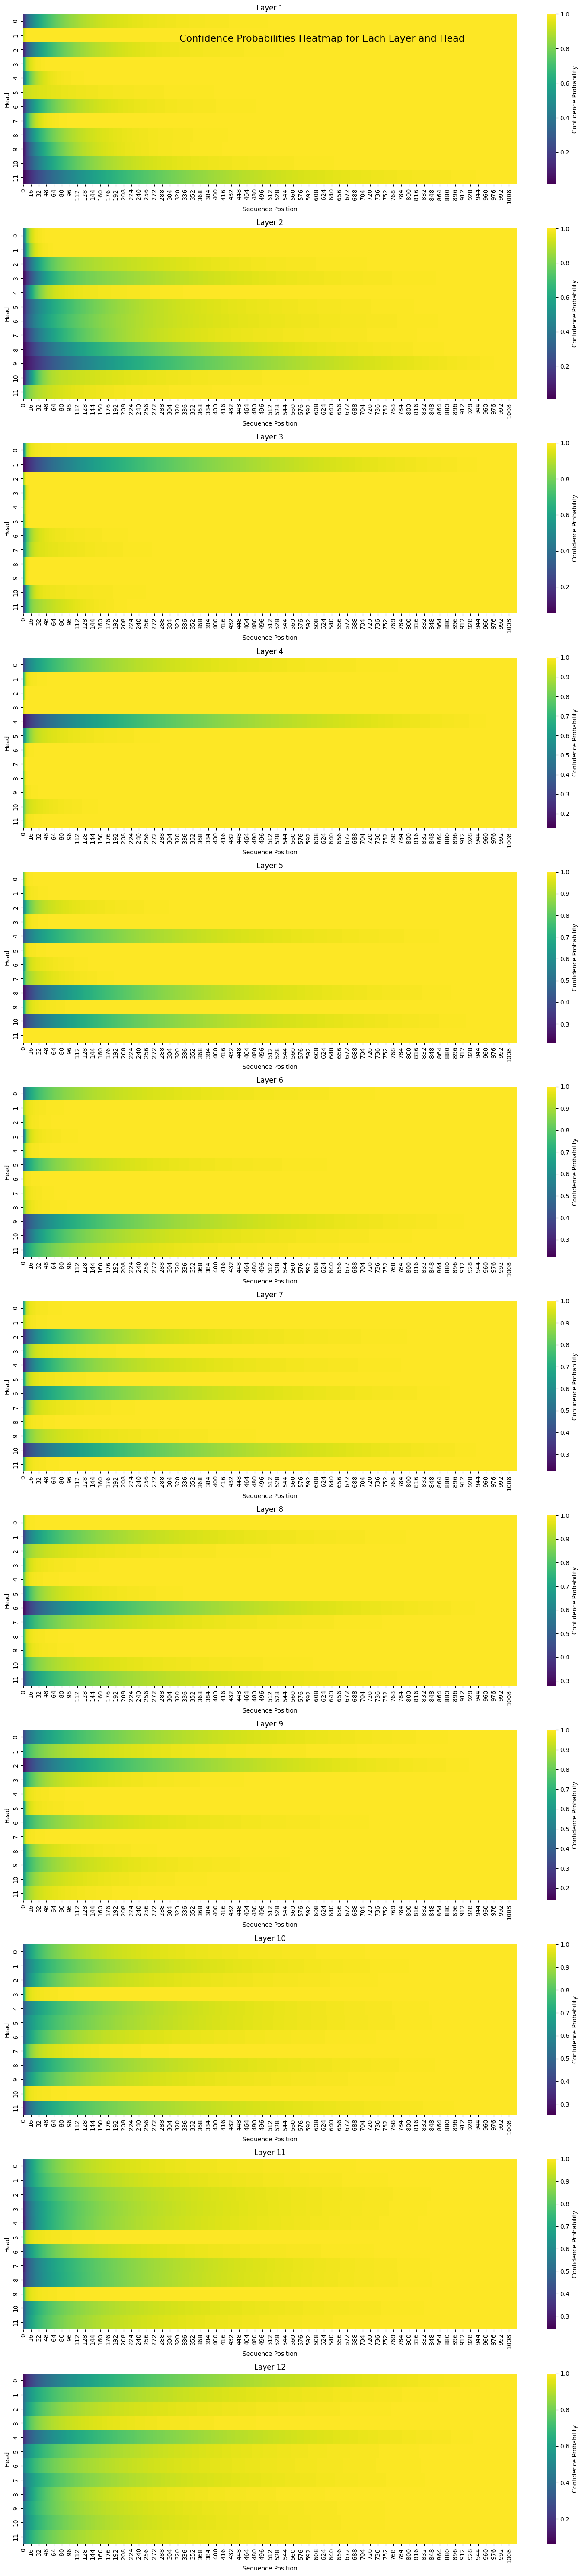

In [ ]:
# %%

plot_confidence_heatmaps(avg_cumsum_metrics_np)

In [ ]:
# %%

def plot_confidence_linechart(cumsum_metrics):
    num_layers, num_heads, seq_length = cumsum_metrics.shape

    # Create a color map for the heads
    colors = plt.cm.rainbow(np.linspace(0, 1, num_heads))

    for layer in range(num_layers):
        # Create a new figure for each layer
        plt.figure(figsize=(15, 8))

        for head in range(num_heads):
            # Get data for the current head
            head_data = cumsum_metrics[layer, head, :]

            # Plot the line for this head
            plt.plot(
                range(seq_length), head_data, color=colors[head], label=f"Head {head}"
            )

        plt.title(f"Cumulative Confidence for Layer {layer}", fontsize=16)
        plt.xlabel("Sequence Position", fontsize=12)
        plt.ylabel("Cumulative Confidence", fontsize=12)
        plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1

        # Add a legend
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

        plt.tight_layout()
        plt.show()

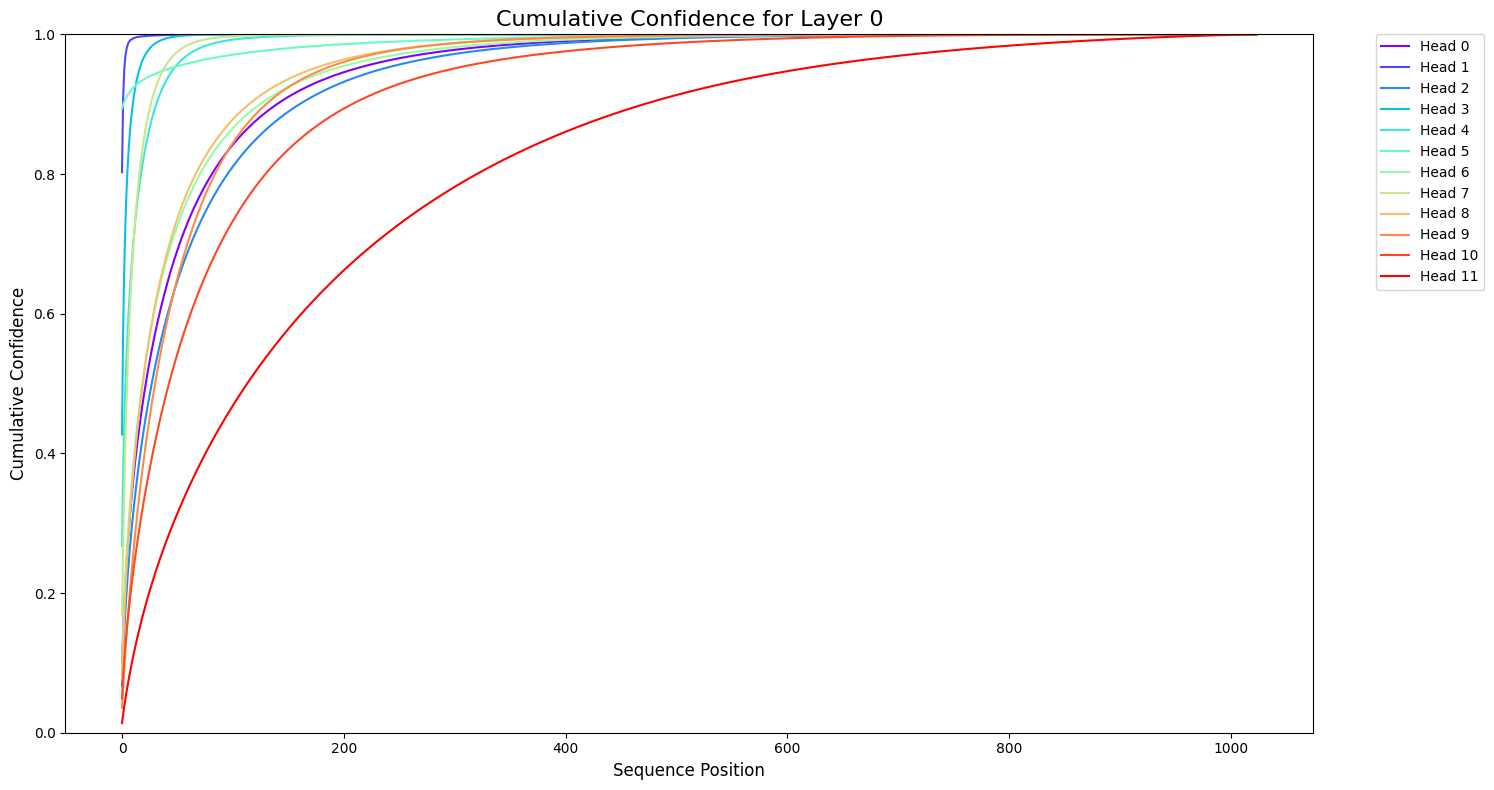

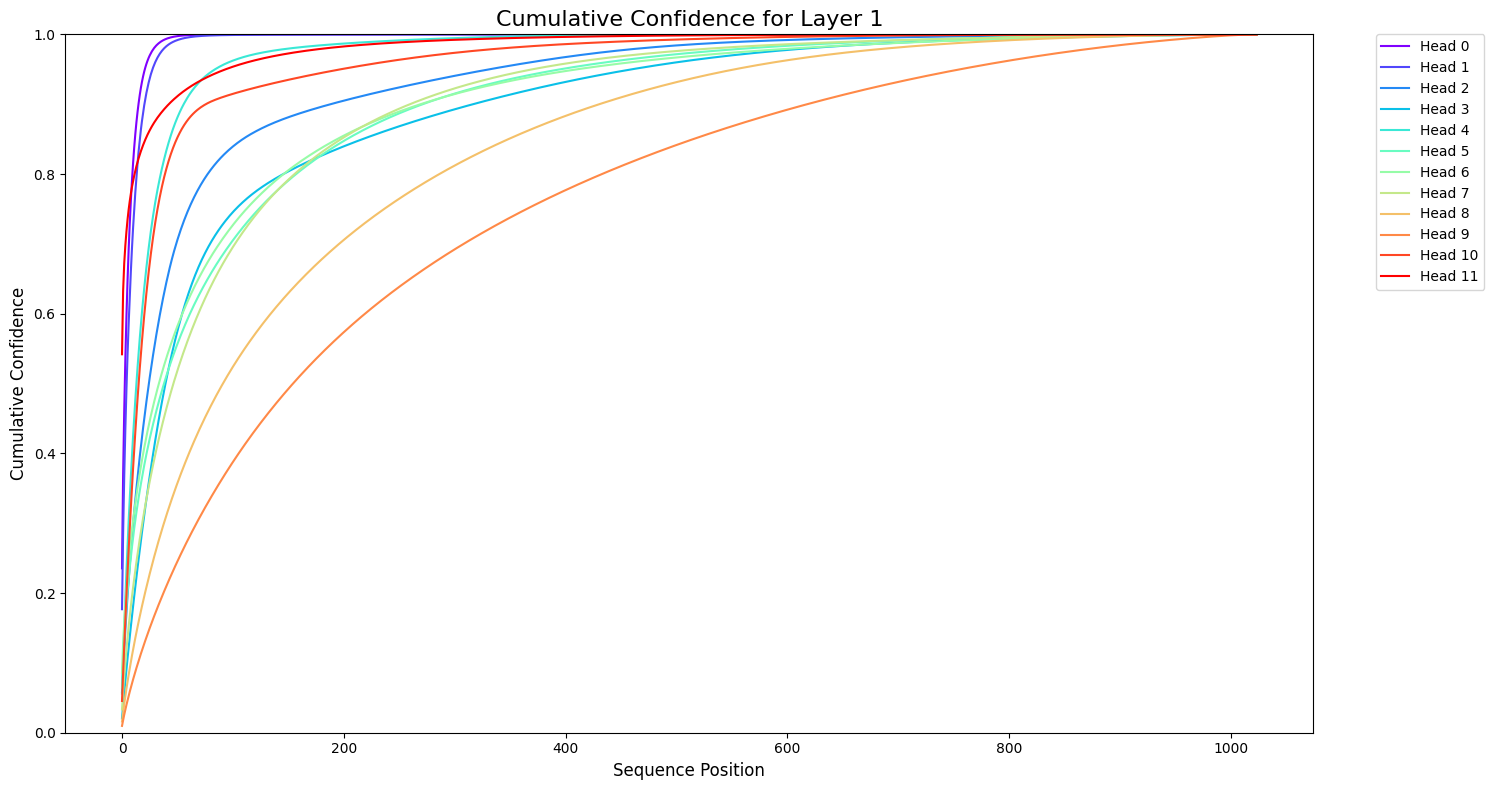

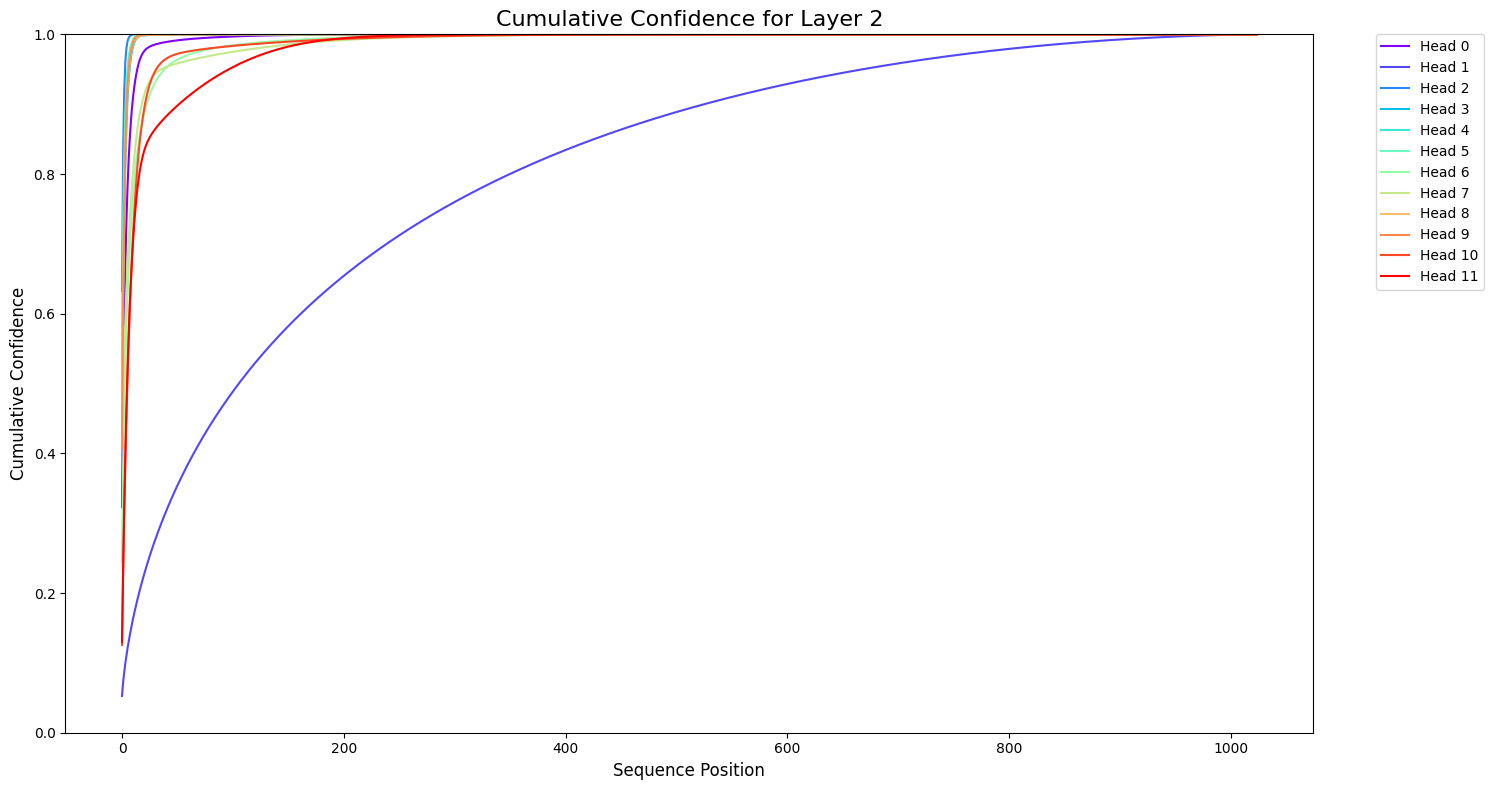

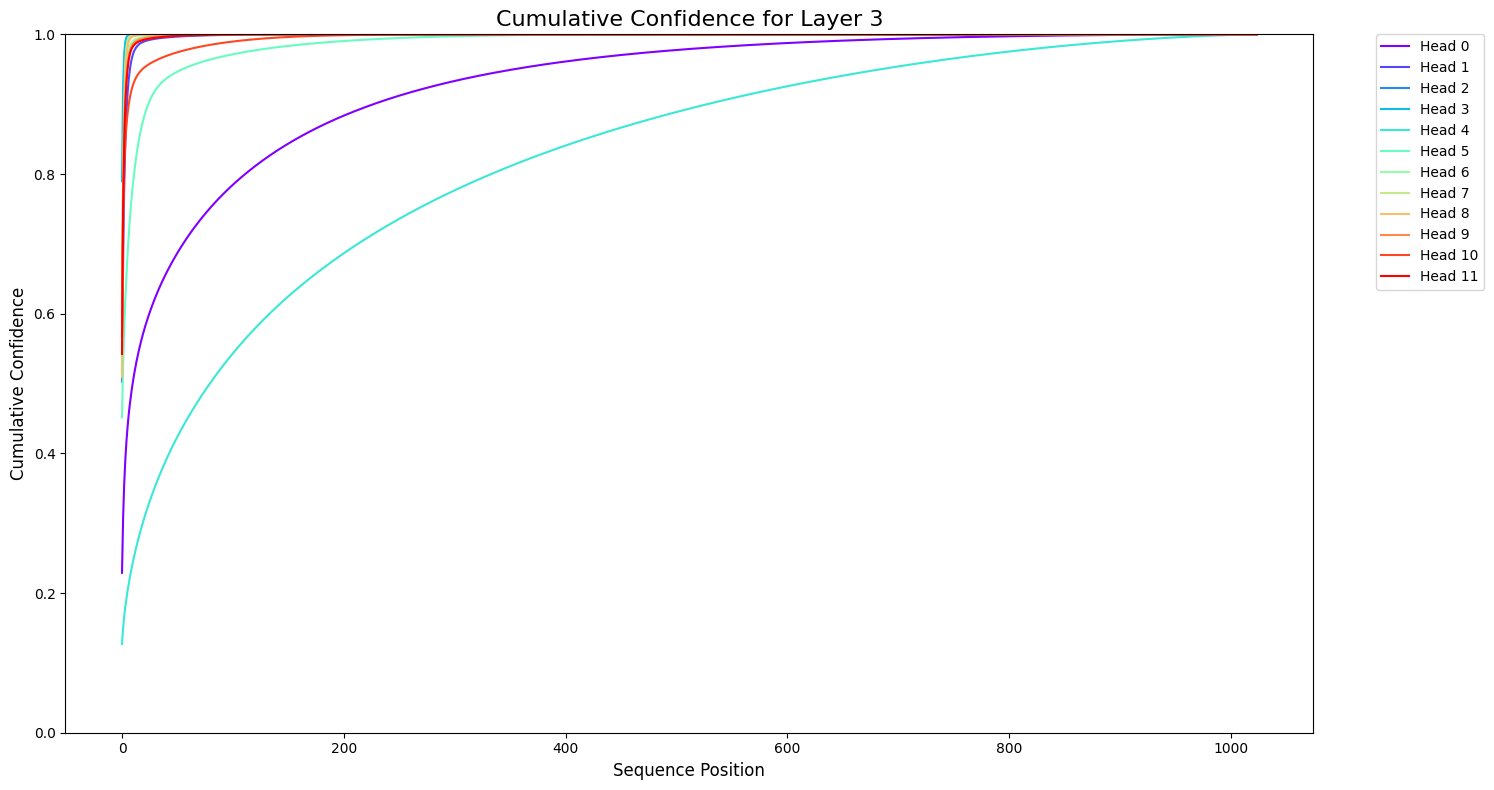

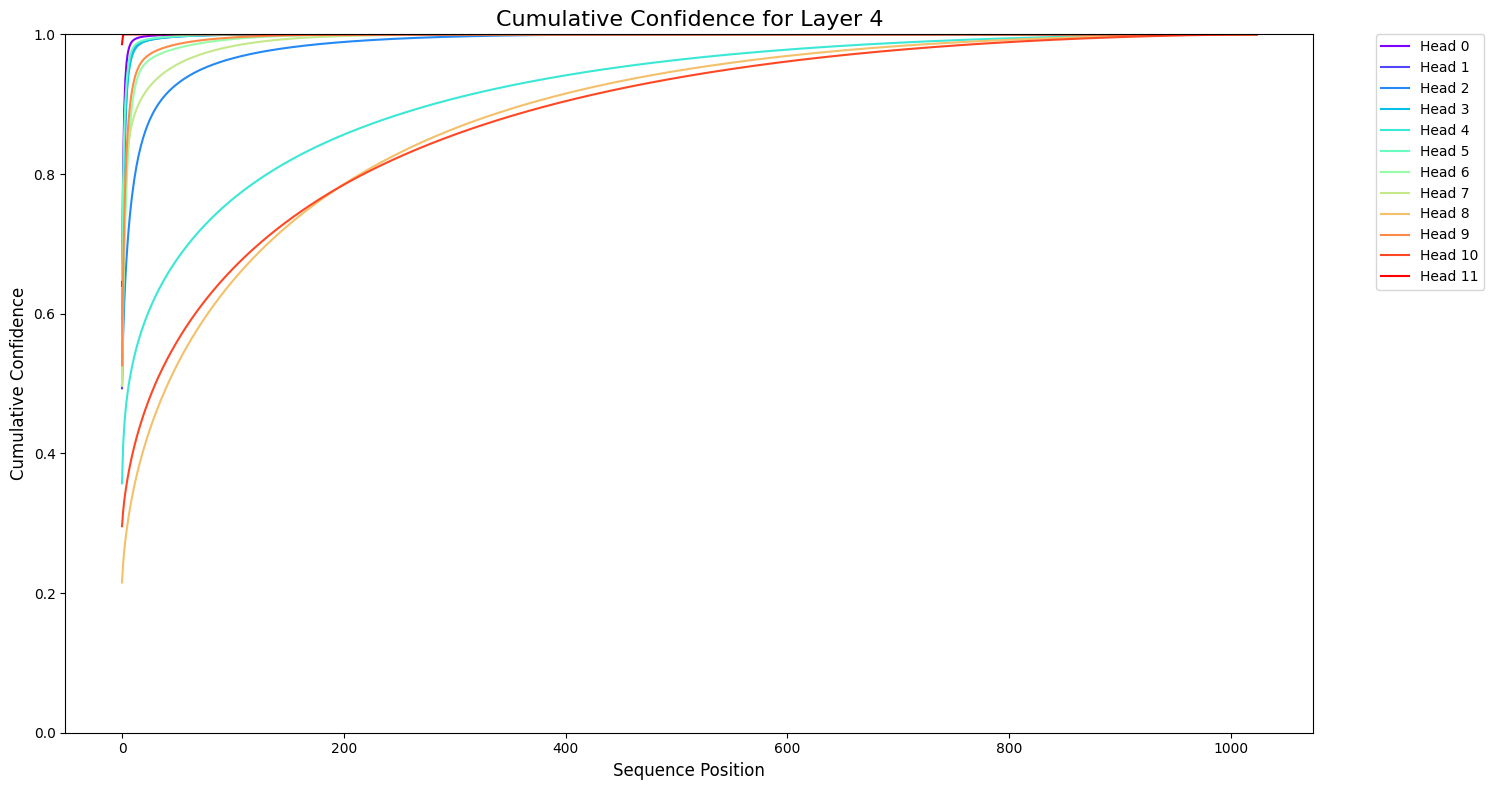

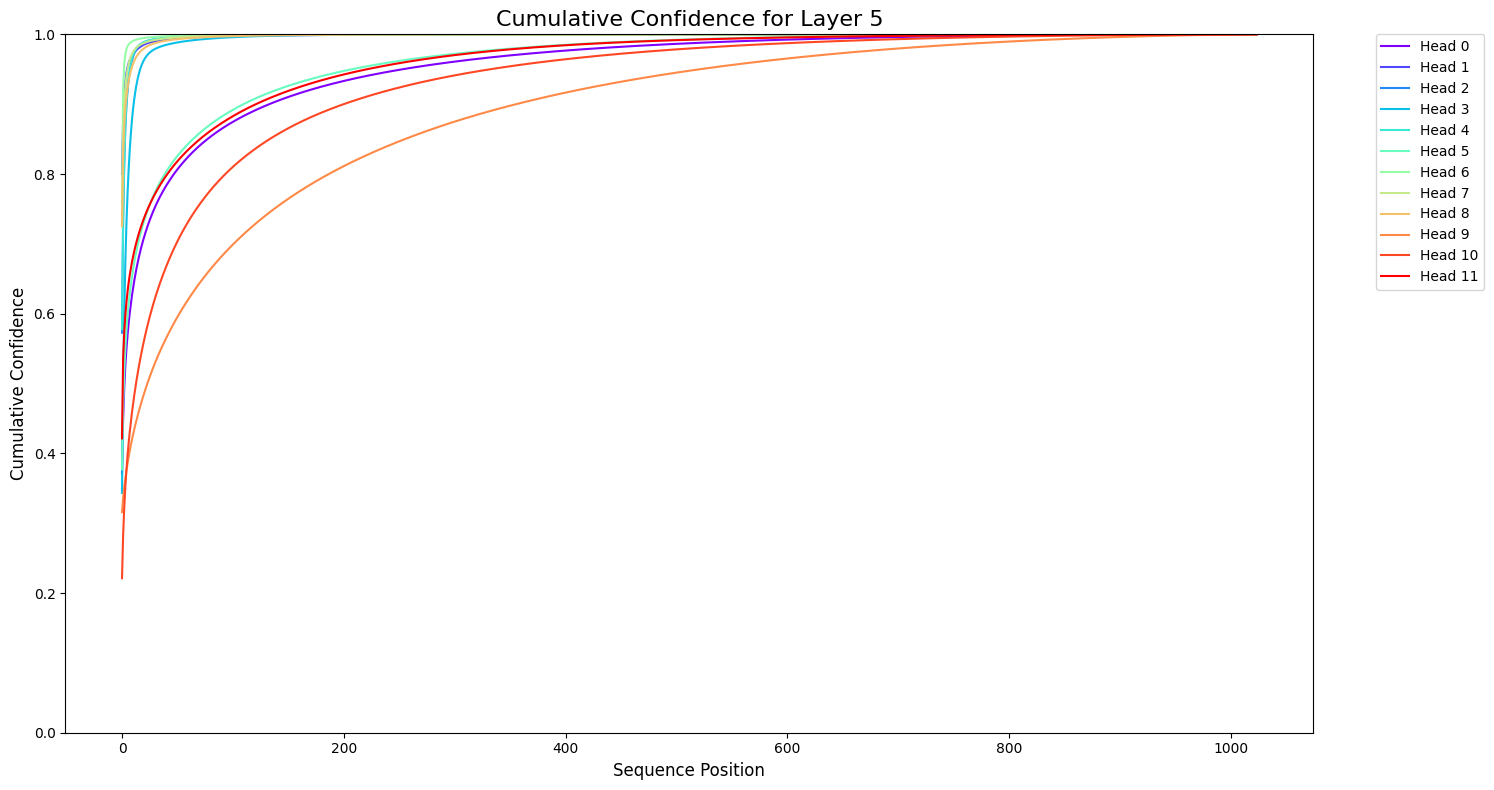

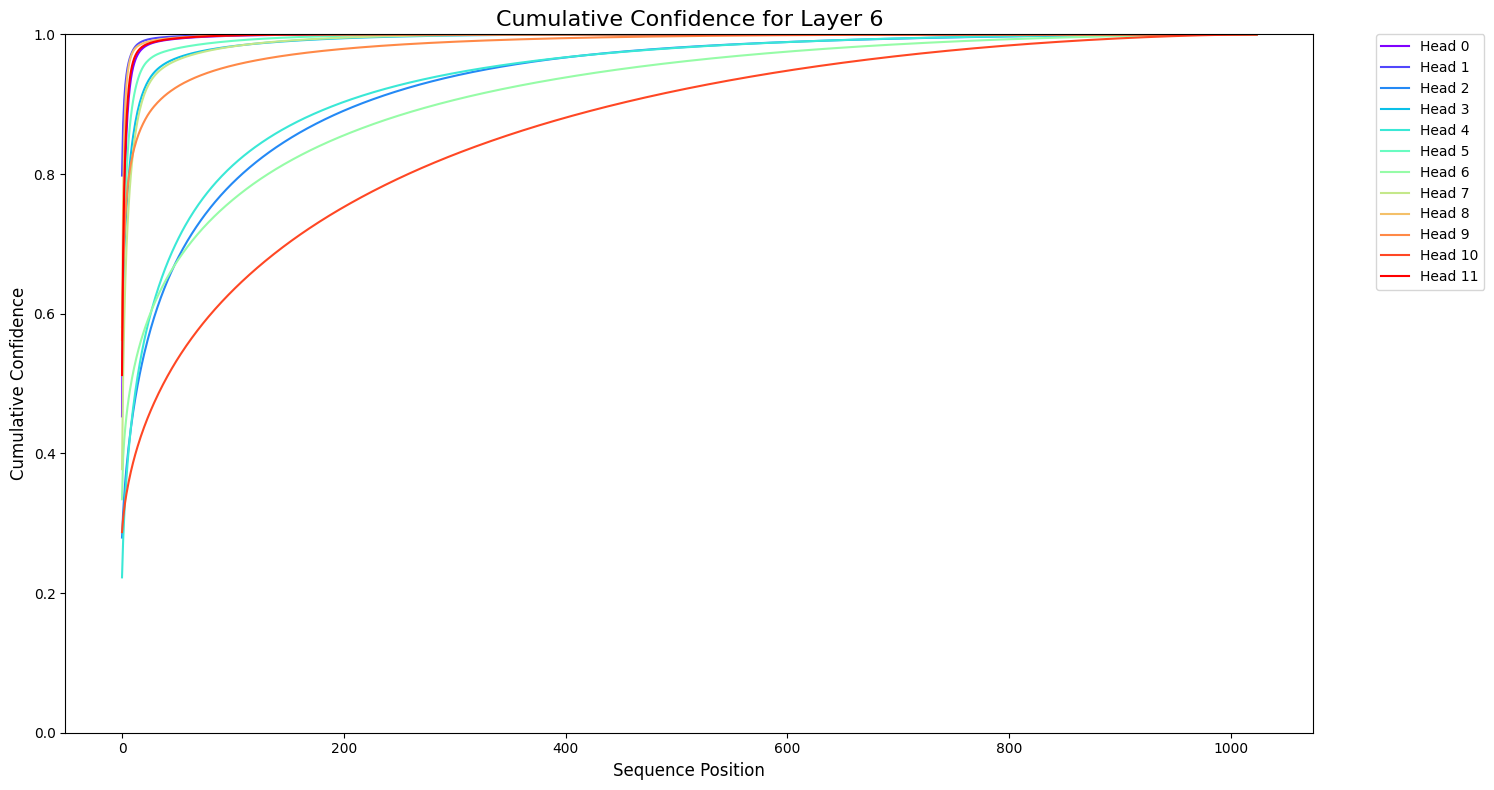

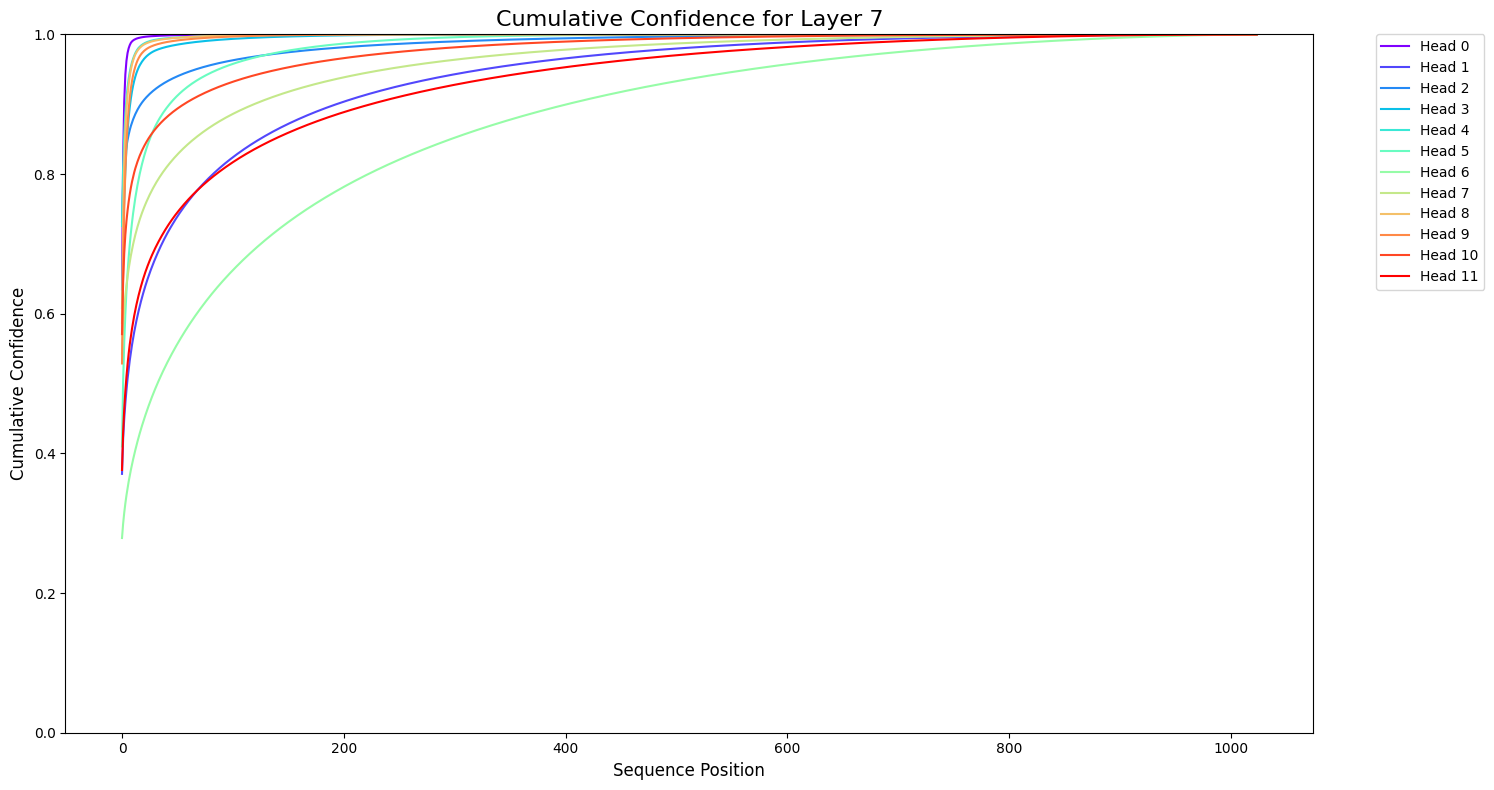

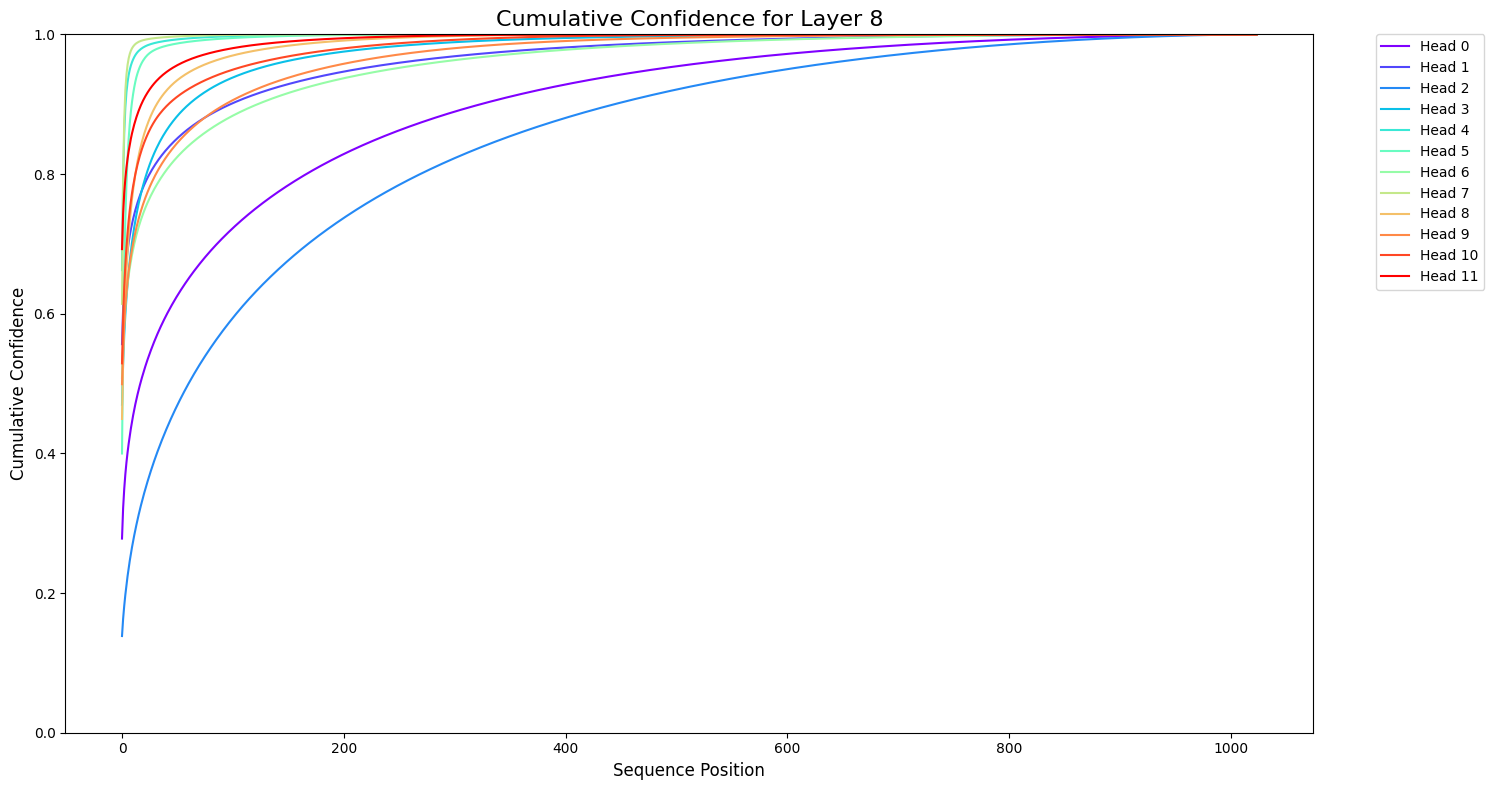

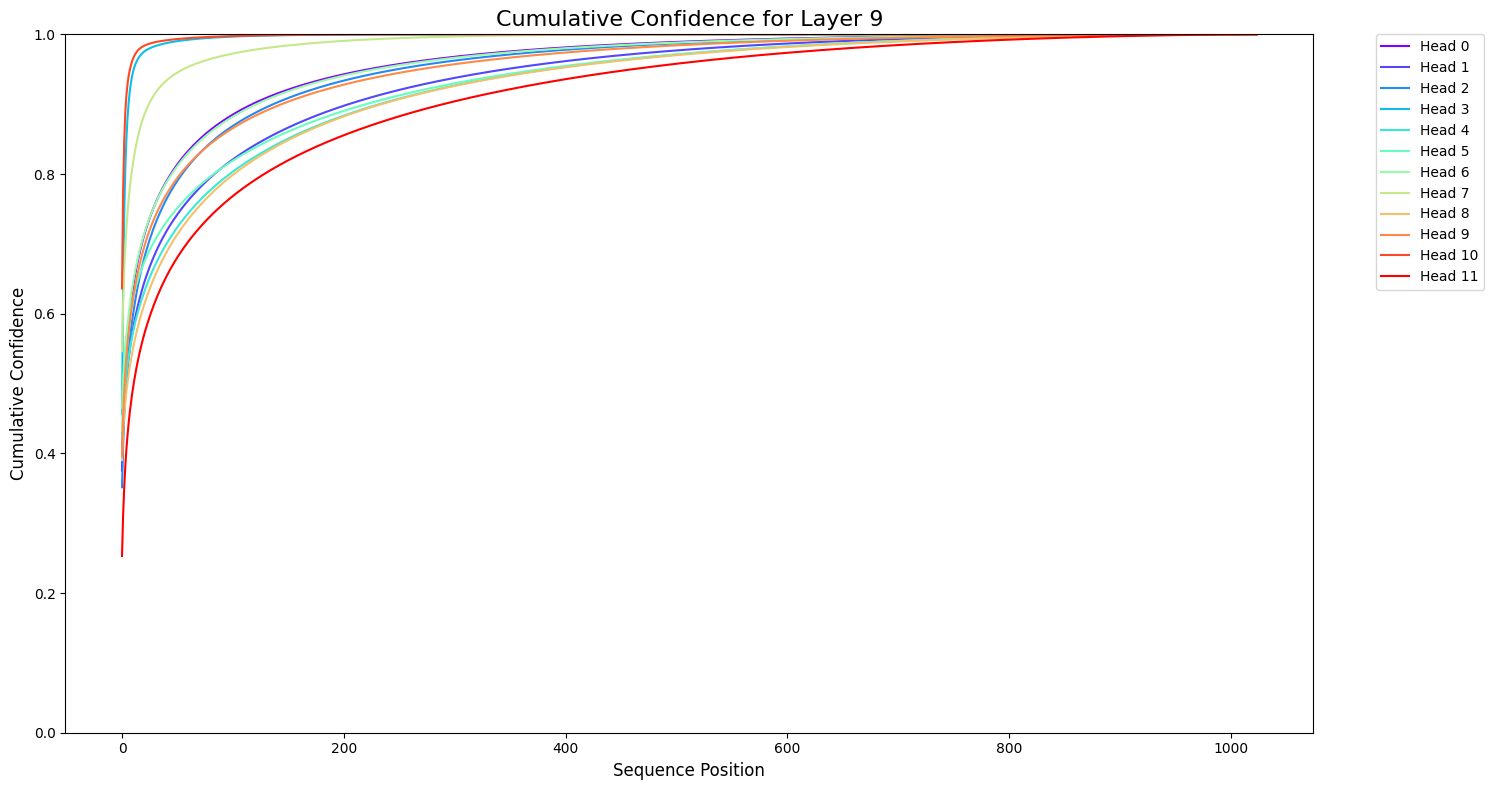

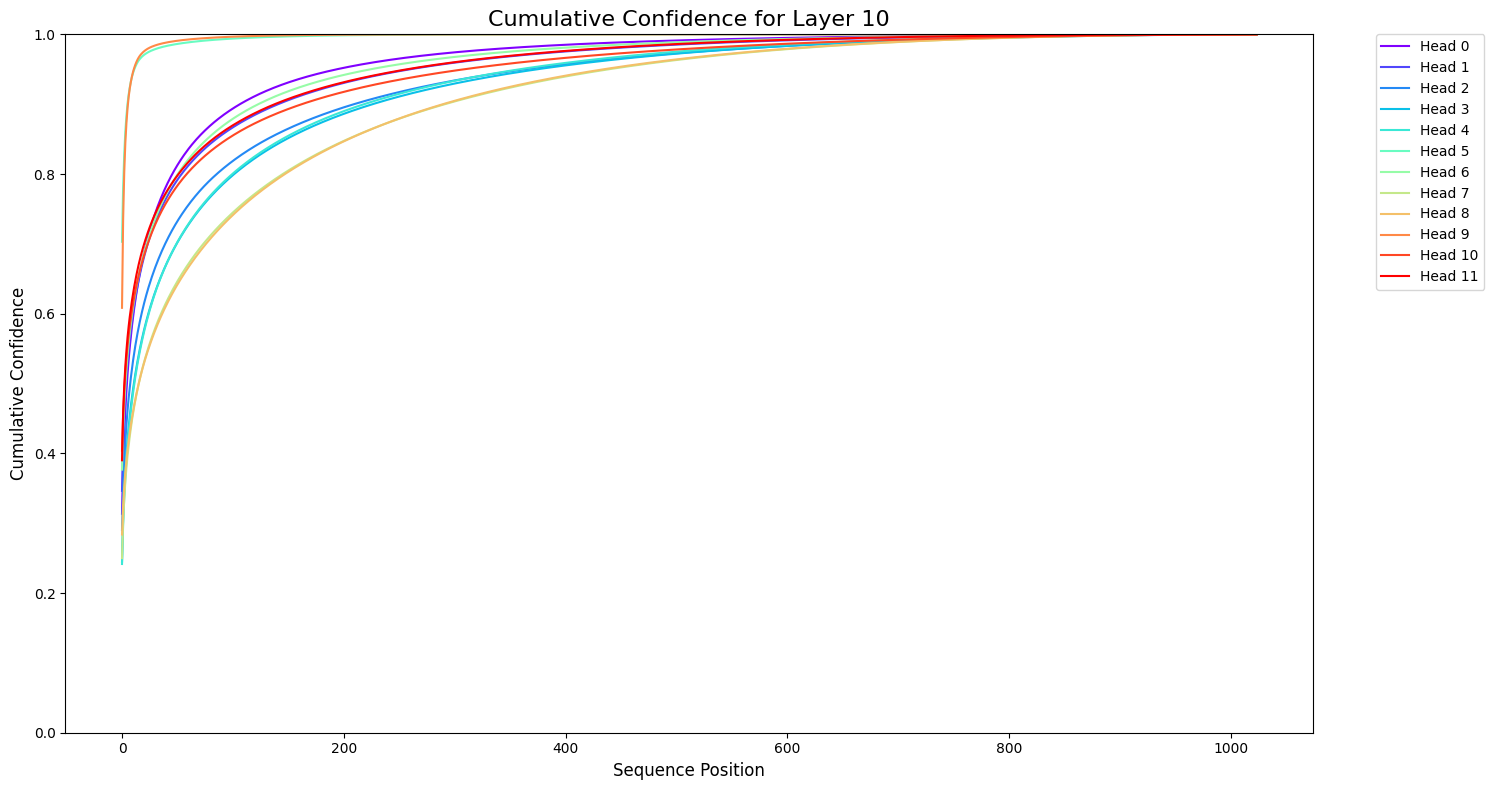

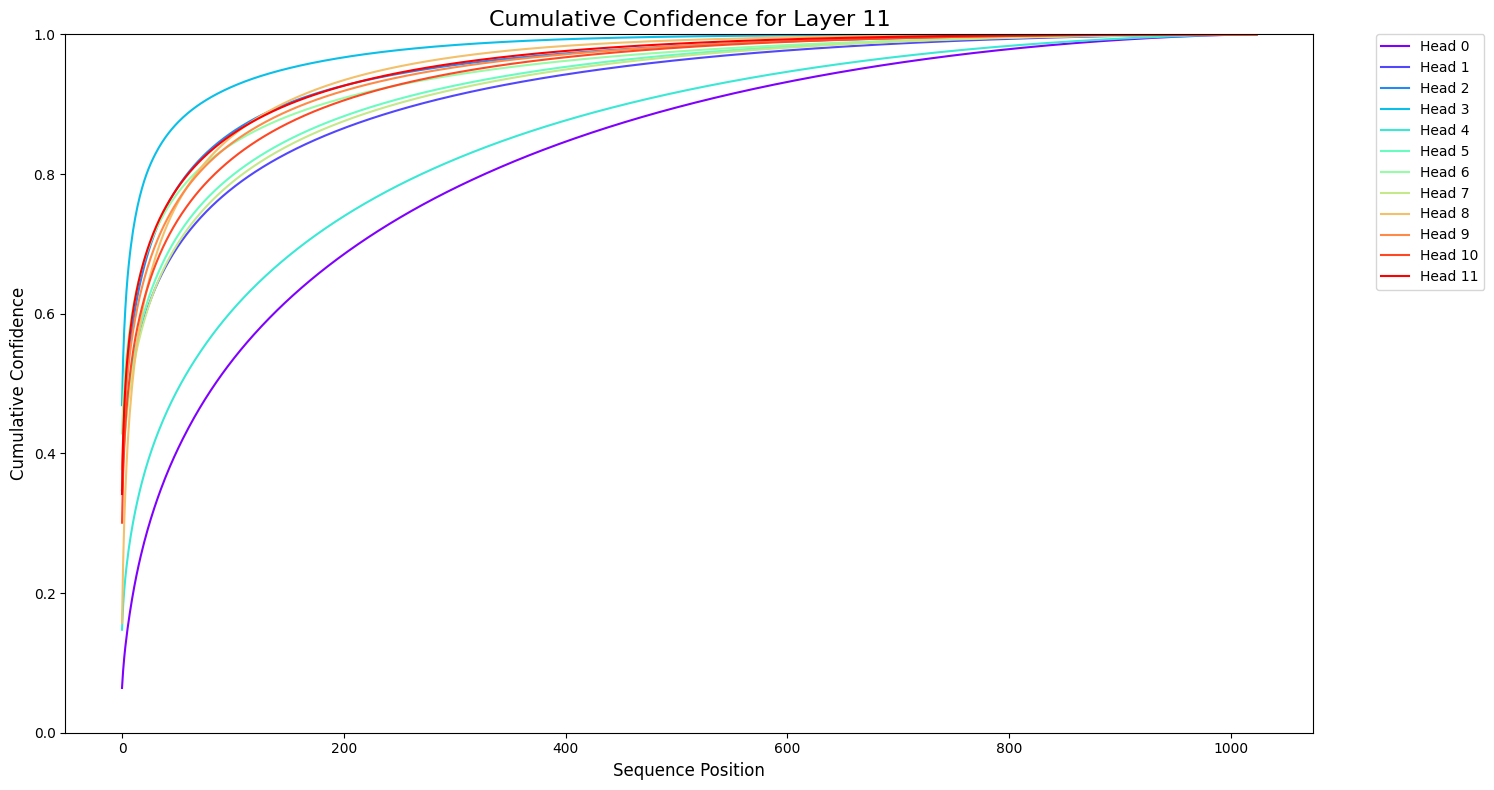

In [ ]:
# %%

plot_confidence_linechart(avg_cumsum_metrics_np)